In [1]:
import draftAnal as DA
import os

DA.resetFolder("./Data/WORKING")

### Required libraries

In [2]:
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pandas as pd
import numpy as np
import pickle as pk
import pylab
from scipy.spatial.distance import euclidean
import seaborn as sns
from fastdtw import fastdtw


## Determine Composition of the Data from INPUT folder

In [14]:
Data = []

for i, directory in enumerate(next(os.walk('./Data/INPUT/'))[1]):
    Data.append(DA.author(directory.lower()))

PINOTTI
POLETTO
VALDANO
GRAVINO
BOKANYI
VANTRIJP
LONDEI
BENTKOWSKI
COLLIAUX
TANI
PETRI
UBALDI
ROUX
AHNE
SORGER
ZAVOJANNI
HANAPPE
WANJEK
TEMIME
MONECHI
AOUAMEUR
PULLANO
LORETO
COLIZZA


## Clean the filenames in order to be easyer to use in the future

In [4]:
for i, author in enumerate(Data):
    author.cleanfilenames()
    Data[i] = author

In [5]:
for i, author in enumerate(Data):
    for j,draft in enumerate(author.drafts):
        draft.CountWords()
        author.drafts[j] = draft
    Data[i] = author

## Calculate the cross compressibility within drafts of a same author

In [6]:
for i, author in enumerate(Data):
    author.createContigs()
    Data[i] = author

In [7]:
for i, author in enumerate(Data):
    author.FindLastMacro()
    Data[i]=author

Copy_of_SEW1_HANAPPE_2_-_30_January__17_43 is last edit of draft 3
Copy_of_SEW1_HANAPPE_2_-_30_January__17_43 is last edit of draft 4


### Compute difference between author convergence trajectories

In [8]:
distance = np.zeros((len(Data), len(Data)))
for i, author1 in enumerate(Data):
    for j, author2 in enumerate(Data):
        x=author1.drafts[author1.Last4].contigData.distance
        y=author2.drafts[author2.Last4].contigData.distance
        distance[i,j], _ = fastdtw(x, y, dist=euclidean)

### Plot cluster structure of the difference matrix

/home/ruggiero/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Use the colorbar set_ticks() method instead.
/home/ruggiero/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


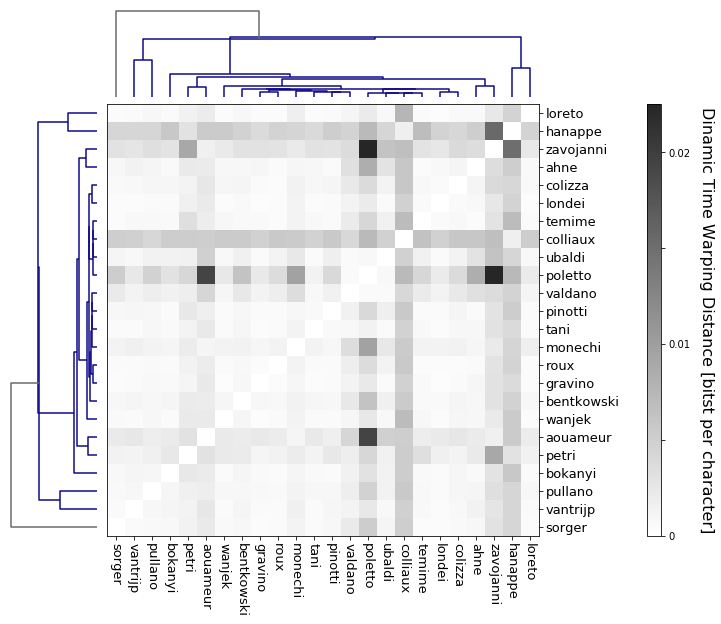

In [10]:
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cm
import matplotlib.colors as colors
cmap = cm.plasma(np.linspace(0.0, 1, 3))
sch.set_link_color_palette([colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(10,10))
ax1 = fig.add_axes([0.162,0.1,0.125,0.6])
Y = sch.linkage(distance, method='centroid')
Z1 = sch.dendrogram(Y, orientation='left', above_threshold_color='dimgrey')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')
# Plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.125])
Z2 = sch.dendrogram(Y, above_threshold_color='dimgrey')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis('off')
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves'][::-1]
idx2 = Z2['leaves']
distance_new = distance[idx1,:]
distance_new = distance_new[:,idx1]
im = axmatrix.matshow(distance, aspect='auto', origin='lower', cmap=sns.cubehelix_palette(light=1, as_cmap=True, hue=0.),
                     vmin=distance.min(),vmax=distance.max())
axmatrix.set_xticks([])
axmatrix.set_yticks([])

axmatrix.set_xticks(range(len(Data)))
axmatrix.set_xticklabels(np.array([d.name for d in Data])[idx2], minor=False, fontsize=13)
axmatrix.xaxis.set_label_position('bottom')
axmatrix.xaxis.tick_bottom()

pylab.xticks(rotation=-90)

axmatrix.set_yticks(range(len(Data)))
axmatrix.set_yticklabels(np.array([d.name for d in Data])[idx2], minor=False, fontsize=13)
axmatrix.yaxis.set_label_position('right')
axmatrix.yaxis.tick_right()

#Plot colorbar.
axcolor = fig.add_axes([1.05,0.1,0.02,0.6])
cbar = pylab.colorbar(im, cax=axcolor)
cbar.ax.set_yticks([0,0.005,0.01,0.015,0.02,0.025,0.03])
cbar.ax.set_yticklabels(['0','','0.01','','0.02','',0.03],fontsize=10)
cbar.set_label('Dinamic Time Warping Distance [bitst per character]', labelpad=24,rotation=270, fontsize=16)
fig.show()
plt.savefig("DTSclustering")

### Show contens of clusters

[['vantrijp', 'pullano'], ['pinotti', 'poletto', 'valdano', 'gravino', 'bokanyi', 'londei', 'bentkowski', 'colliaux', 'tani', 'petri', 'ubaldi', 'roux', 'ahne', 'zavojanni', 'wanjek', 'temime', 'monechi', 'aouameur', 'colizza'], ['hanappe', 'loreto'], ['sorger']]


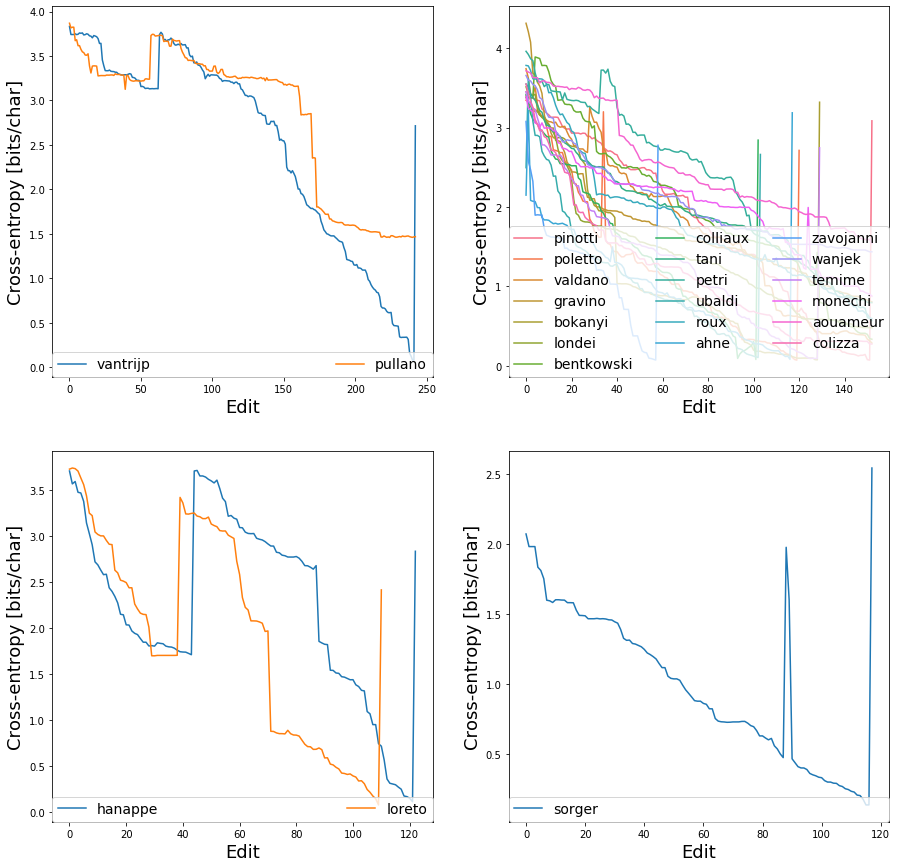

In [11]:
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rc('axes', titlesize=14) 
pylab.rcParams.update(params)
k = 4 #numero di cluster
ClIndex = sch.fcluster(Y, k, criterion='maxclust')

clusters = [[] for _ in range(0,k)]
for i, author in enumerate(Data):
    clusters[ClIndex[i]-1].append(author)

SortedNames = []
for cluster in clusters:
    SortedNames.append([author.name for author in cluster])
print(SortedNames)
    
trajes = list()
for cluster in clusters:

    df=pd.DataFrame()
    for i, author in enumerate(cluster):
        df_temp = author.drafts[author.Last4].contigData[["Edit", "distance"]].set_index("Edit")
        df_temp.rename(columns = {"distance":author.name}, inplace=True)
        df[author.name] = df_temp[author.name]
    trajes.append(df)
f, axes = plt.subplots(2, 2, figsize=(15,15))
i=0
for df in trajes:
    ax = axes[int(np.floor(i/2)), i%2]
    df = df.reset_index().melt(id_vars=['Edit'])
    g=sns.relplot( x="Edit", y='value', kind="line", hue = "variable", data=df,
                 ax=ax, legend=False)
    ax.legend(SortedNames[i],loc='lower left',   ncol=3, mode="expand", borderaxespad=0.)
    ax.set_ylabel("Cross-entropy [bits/char]",fontsize=18)
    ax.set_xlabel("Edit",fontsize=18)
    i=i+1
    plt.close(2)
plt.savefig("ClusterTrajectories.jpeg")

In [ ]:
for i, author in enumerate(Data):
    author.slide(C=True)
    Data[i] = author

## Save Data

In [ ]:
from datetime import datetime
now = datetime.now()
timestmp = now.strftime("%d-%m-%Y-%H-%M")
print(timestmp)
pk.dump( Data, open( "./Data/OUTPUT/Data"+timestmp+".p", "wb" ) )

In [ ]:
with open("./Data/OUTPUT/Data07-11-2019-21-56.p","rb") as file:
    Data = pk.load(file)

## Plot the cross compressibility for the last draft in the author work

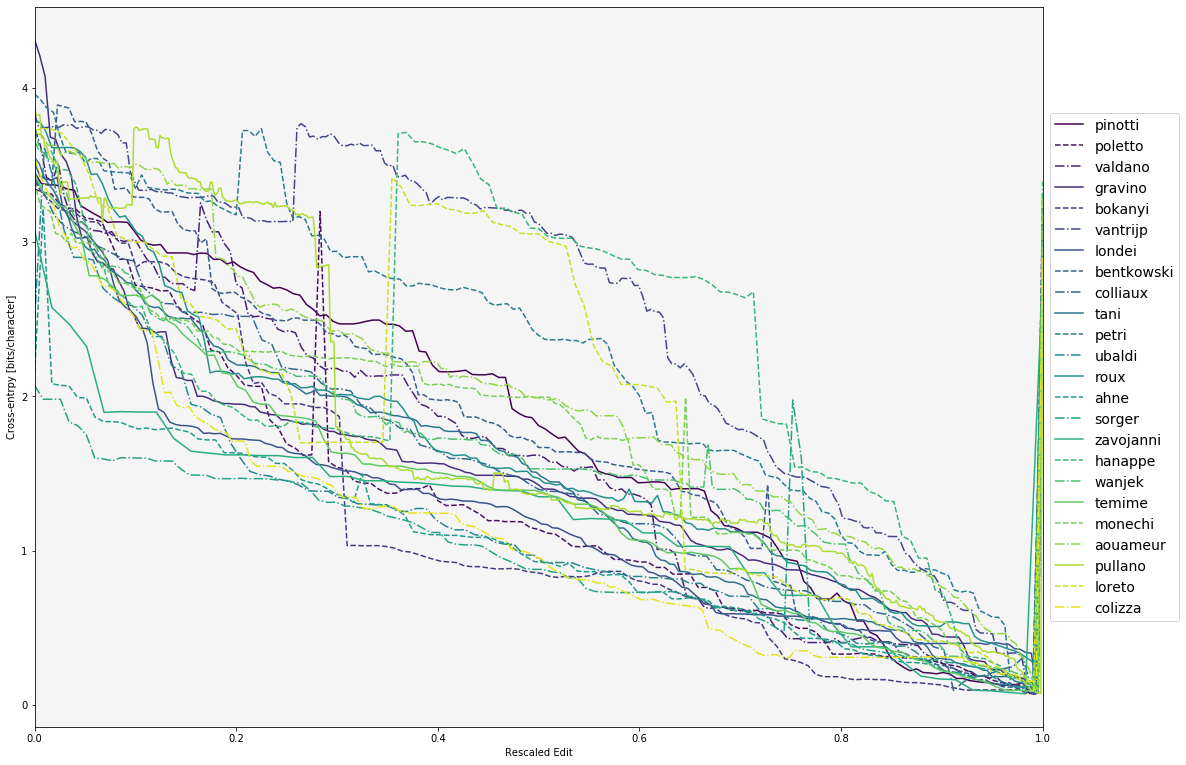

In [12]:
import pylab
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rc('axes', titlesize=14) 
x = np.linspace(0, 5, 100)
cmap = plt.get_cmap('viridis')
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
fig = plt.figure(figsize=(14,10))
ax = fig.add_axes([1,1,1,1])
ax.set_facecolor('whitesmoke')
N = len(Data)
for i,author in enumerate(Data):
    color = cmap(float(i)/(N))
    linestyle = LINE_STYLES[i%3]
    author.drafts[author.Last4].contigData.plot(ax = ax, x='Edit_norm', y='distance', c=color,ls=linestyle, label=author.name)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Cross-entrpy [bits/character]")
plt.xlabel("Rescaled Edit")
plt.savefig('LastDraftCE.png', bbox_inches='tight',format='png')

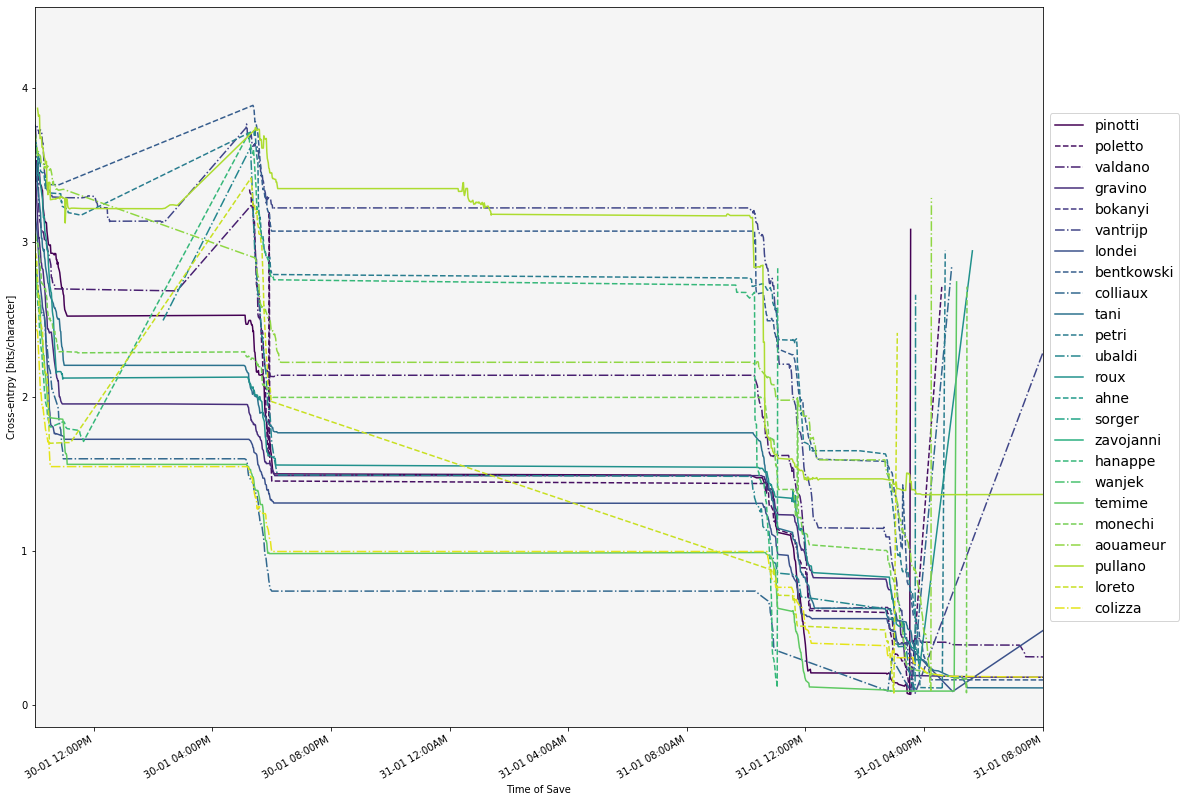

In [13]:
import datetime as datetime
params = {'legend.fontsize': 14,
          'legend.handlelength': 2}
plt.rc('axes', titlesize=14) 
import matplotlib.dates as mdates
x = np.linspace(0, 5, 100)
cmap = plt.get_cmap('viridis')
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
fig = plt.figure(figsize=(14,10))
ax = fig.add_axes([1,1,1,1])
ax.set_facecolor('whitesmoke')
N = len(Data)
for i,author in enumerate(Data):
    color = cmap(float(i)/N)
    linestyle = LINE_STYLES[i%3]
    author.drafts[author.Last4].contigData.reset_index().plot(ax = ax, x='datetime', y='distance', c=color,ls=linestyle, label=author.name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim([datetime.datetime(2019, 1, 30, 10, 00), datetime.datetime(2019, 1, 31, 20,00)])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m %I:%M%p"))
plt.ylabel("Cross-entrpy [bits/character]")
plt.xlabel("Time of Save")
plt.savefig('LastDraftCErealTime.png', bbox_inches='tight',format='png')

## Plot different properties of the cross compressibility within drafts

In [ ]:
DA.plot_sliding_prop(Data, 'avg')

In [ ]:
DA.plot_sliding_prop(Data, 'var')

In [ ]:
DA.plot_sliding_prop(Data, 'var1')

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
sns.set_style("white")
sns.set_context("poster")
for i,author in enumerate(Data[:2]):
    df = author.drafts[author.Last1].sliding.data
    df = df.reset_index()
    df['X'] = df['index']*50
    df['Macro Edit 1'] =df[0]
    del(df[0])
    df['Macro Edit 2'] = author.drafts[author.Last2].sliding.data[0]
    df['Macro Edit 3'] = author.drafts[author.Last3].sliding.data[0]
    df['Macro Edit 4'] = author.drafts[author.Last4].sliding.data[0]
    df['Author'] = author.name


    df = df.melt(id_vars=['index', 'X', 'Author'], var_name='Edit', value_name='CrossEnt')
    g=sns.relplot( x="X", y='CrossEnt', kind="line", data=df, hue='Edit',
                  height=8.27, aspect=11.7/8.27)
    plt.ylabel("Cross-entropy [bits/character]")
    plt.xlabel("Window Beginning [character]")
    sns.despine()
    plt.title(author.name)
    plt.savefig(author.name+"_slidingMacro")
    g=sns.relplot( x="X", y='CrossEnt', kind="line", data=df,
                  height=8.27, aspect=11.7/8.27)
    plt.ylabel("Cross-entropy [bits/character]")
    plt.xlabel("Window Beginning [character]")
    sns.despine()
    plt.title(author.name)
    plt.savefig(author.name+"_slidingMacroAVG")

In [ ]:
author = Data[4]
author.drafts[author.Last2].sliding.data

In [ ]:
df